In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [20]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [5] * 12)

Goal reached! final score= 56.966827307742335
finish_time 4500
machine_operation_rate [0.4666666666666667, 0.8444444444444444, 0.6666666666666666, 0.4444444444444444, 0.4, 0.8222222222222222, 1.0, 0.5333333333333333]
job_deadline [900, 1300, 1800, 900, 1800, 1250, 2400, 1050, 1050, 900, 1400, 2000, 900, 1200, 1700, 2300, 1050, 1400, 1500, 2200, 3000, 750, 1100, 900, 1400, 2000, 1050, 2300, 1600, 3100, 1050, 1500, 2800, 2100, 3700]
job_time_exceeded [900, 3000, 1300, 3600, 2000, 1850, 1400, 1450, 0, 800, 2400, 900, 300, 400, 1300, 1000, 650, 1200, 200, 500, 0, 550, 1900, 300, 500, 700, 450, 300, 300, 900, 950, 100, 700, 1200, 600]
current_repeats [3, 4, 1, 1, 3, 4, 2, 3, 2, 3, 4, 5]
3325.0


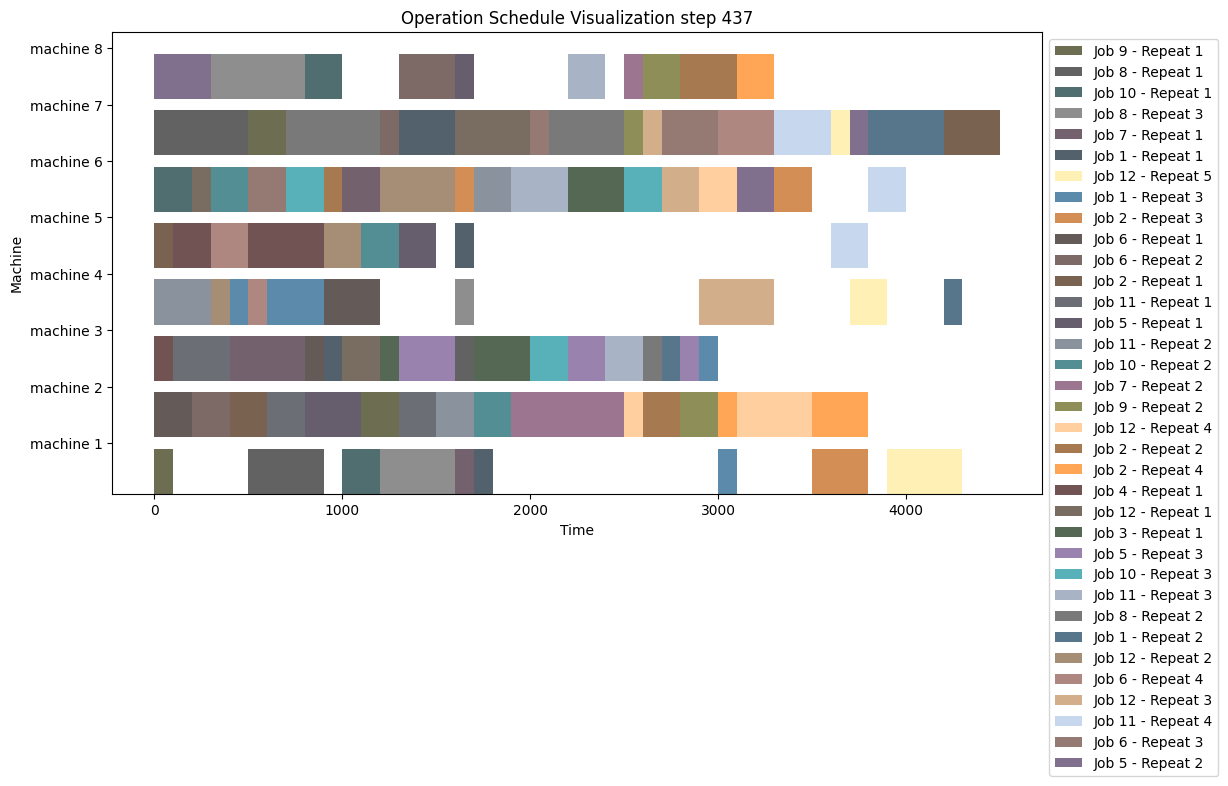

In [27]:
step = 0
obs, info = env.reset()
#print(info['schedule_buffer'])

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    
    
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        print('current_repeats', info['current_repeats'])
        print(env.target_time)
        env.render()
        break

In [15]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, max_repeats):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, max_repeats = max_repeats, test_mode = test_mode)
        return env
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [3]*12), make_env(job_paths[0], machine_paths[0], False, [5]*12)]

vec_env = SubprocVecEnv(envs)

In [16]:
model = PPO('MultiInputPolicy', vec_env, verbose=1).learn(1000000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2308 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1633        |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012007276 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.56       |
|    explained_variance   | -0.00803    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 25.7        |
-----------------------------------------
-----------------

In [17]:
env1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [3] * 12, test_mode = True)
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [5] * 12, test_mode = False)

custom_env = [env1, env2]

Goal reached! final score= 75.07538857806334
job_deadline [900, 1300, 1800, 900, 1250, 1800, 1050, 1600, 2300, 1050, 1500, 2200, 900, 1400, 2000, 900, 1200, 1700, 1050, 1400, 2000, 1500, 2200, 3000, 750, 1100, 1600, 900, 1400, 2000, 1050, 1600, 2300, 1050, 1500, 2100]
job_time_exceeded [200, 0, 0, 900, 1150, 1200, 450, 200, 100, 1150, 1400, 1400, 0, 0, 0, 800, 1000, 900, 0, 0, 0, 500, 300, 500, 350, 1300, 1300, 700, 1700, 1400, 50, 0, 0, 750, 1000, 1100]
current_repeats [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3000.0


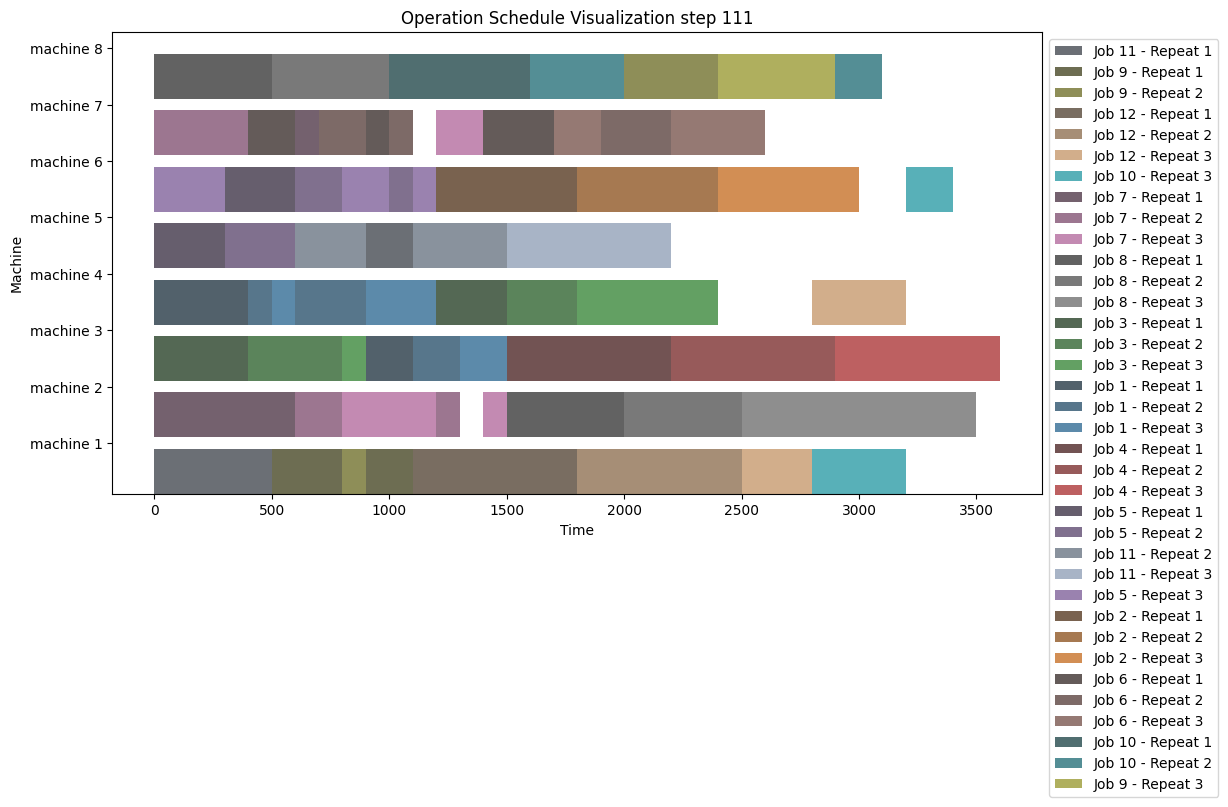

Goal reached! final score= 62.702859110362624
job_deadline [900, 900, 1250, 1800, 2400, 1050, 2300, 1600, 3100, 1050, 900, 1400, 900, 1200, 2300, 1700, 3100, 1050, 1400, 2000, 1500, 2200, 3000, 750, 1600, 1100, 2200, 900, 1400, 2000, 1050, 1600, 2300, 1050, 1500, 2800, 2100, 3700]
job_time_exceeded [200, 400, 550, 900, 600, 0, 0, 0, 0, 650, 0, 0, 800, 1100, 800, 1700, 1400, 0, 0, 0, 800, 200, 0, 1650, 1800, 1800, 1700, 700, 2100, 1700, 50, 0, 0, 450, 700, 500, 800, 300]
current_repeats [1, 4, 4, 1, 2, 5, 3, 3, 4, 3, 3, 5]
3325.0


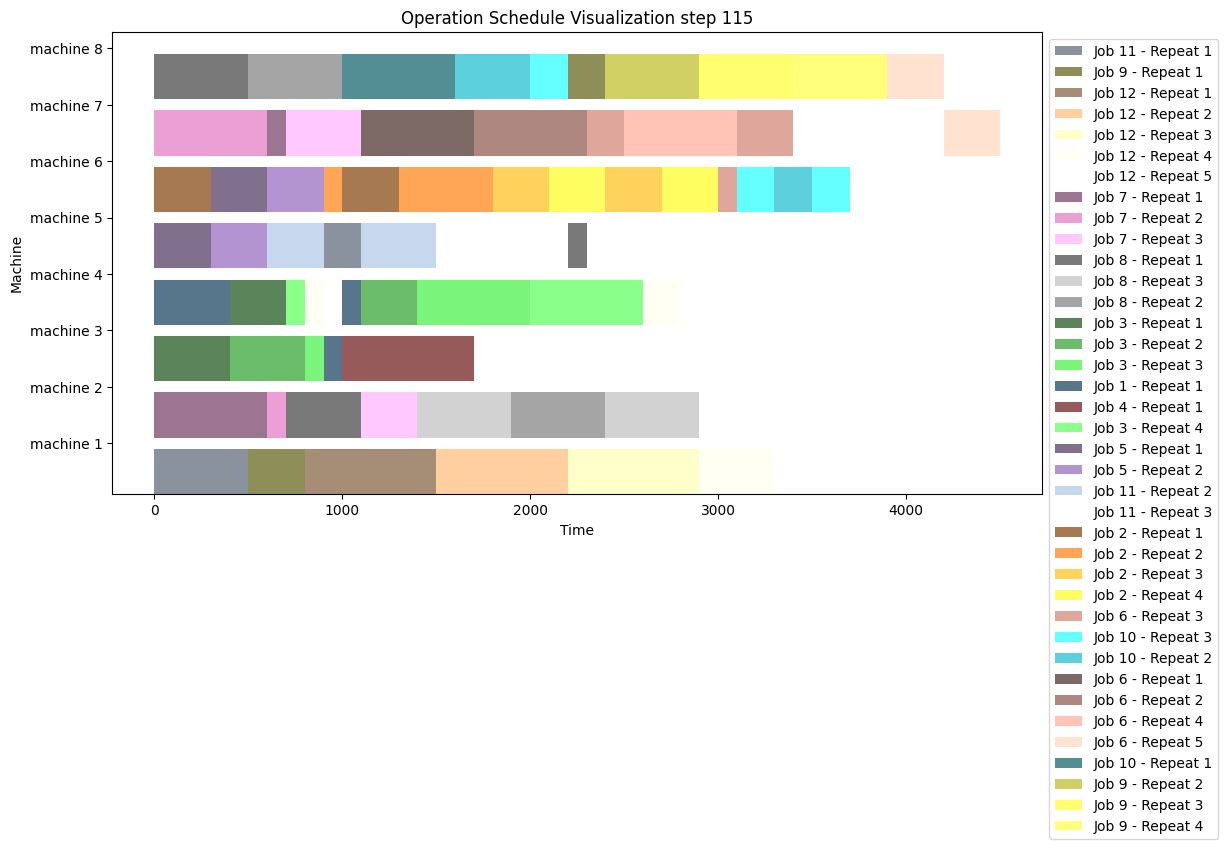

In [33]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("Goal reached!", "final score=", reward)
            print('job_deadline', info['job_deadline'])
            print('job_time_exceeded', info['job_time_exceeded'])
            print('current_repeats', info['current_repeats'])
            print(env.target_time)
            env.render()
            break

In [29]:
model.save("PPO_random_repeat")